In [93]:
import os
import sys
import re
import csv
import warnings
import pickle
import datetime
import tensorflow as tf 
import pandas as pd
import traceback
import time 
import json
import numpy as np 
from collections import defaultdict
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import Input 
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Embedding, BatchNormalization
warnings.filterwarnings("ignore")

cur_path=os.getcwd()
path=cur_path+'/topic_cls_data/train/train.csv'
word_dict = defaultdict(int)
with open(path, 'r', encoding='utf-8') as f:
    rdr = csv.reader(f, delimiter=',', quotechar='"')
    for row in rdr:
        txt = re.sub("^\s*(.-)\s*$", "%1", row[2]).replace("\\n", "\n").replace('\\', ' ')
        txt = txt.split()
        for word in txt:
            word_dict[word.lower()]+=1
word_list=sorted(word_dict.items(), key=lambda d: -d[1])
word_index={'<pad>': 0, '<start>': 1, '<unknown>': 2, '<unused>': 3}
for i in range(29996):
    word_index[word_list[i][0]]=i+4

In [39]:
import os
import json
import sagemaker
from sagemaker.tensorflow.serving import Model
from sagemaker import get_execution_role
from matplotlib import pyplot as mlt
import boto3
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
#bucket = 'bilstm-att-data6893'

In [23]:
bucket

'sagemaker-us-east-2-288882751603'

In [31]:
prefix = 'tf-serving'
model_data = sagemaker_session.upload_data('topic_cls.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))

In [32]:
model_data

's3://sagemaker-us-east-2-288882751603/tf-serving/model/topic_cls.tar.gz'

In [33]:
tensorflow_serving_model = Model(model_data=model_data,
                                 role=role,
                                 framework_version='2.4',
                                 sagemaker_session=sagemaker_session)

The class sagemaker.tensorflow.serving.Model has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [34]:
predictor = tensorflow_serving_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

In [ ]:
# from sagemaker.deserializers import JSONDeserializer
# from sagemaker.serializers import CSVSerializer

# predictor = tensorflow_serving_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge', serializer=CSVSerializer(), deserializer=JSONDeserializer())

In [35]:
predictor.endpoint_name

'tensorflow-inference-2021-12-01-04-20-34-109'

In [43]:
def one_hot_encode(raw_y, num_classes):
    index = np.array(raw_y)
    out = np.zeros((index.shape[0], num_classes))
    out[np.arange(index.shape[0]), index-1] = 1
    return out 

def load_data(path, max_seq_len, word_index, num_classes):
    raw_y = []
    raw_x = []
    with open(path, 'r', encoding='utf-8') as f:
        rdr = csv.reader(f, delimiter=',', quotechar='"')
        for row in rdr:
            raw_y.append(int(row[0]))
            txt = re.sub("^\s*(.-)\s*$", "%1", row[2]).replace("\\n", "\n").replace('\\', ' ').split()
            txt_len = len(txt)
            x = np.zeros(max_seq_len, dtype = np.int32)
            if txt_len <= max_seq_len:
                for i in range(txt_len):
                    try:
                        x[i]=word_index[txt[i]]
                    except:
                        x[i]=2
            else:
                for i in range(txt_len-max_seq_len, txt_len):
                    try:
                        x[i - txt_len + max_seq_len] = word_index[txt[i]]
                    except:
                        x[i - txt_len + max_seq_len]=2
            raw_x.append(x)
    all_x = np.array(raw_x)
    all_y = one_hot_encode(raw_y, num_classes)
    return all_x, all_y

In [44]:
max_seq_len = 128
num_classes = 3
cur_path=os.getcwd()
test_path=cur_path+'/topic_cls_data/test/test.csv'
test_x, test_y = load_data(test_path, max_seq_len, word_index, num_classes)

In [50]:
preds = []
for i in range(238):
    input_x=test_x[i*32:(i+1)*32]
    raw_prob = np.array(predictor.predict(input_x)['predictions'])
    label = np.argmax(raw_prob,axis=1)
    preds.extend(label)

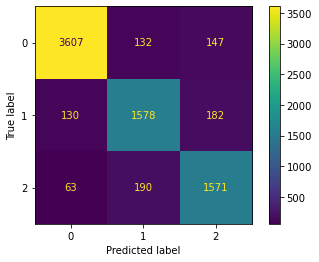

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels=np.argmax(test_y, axis=1)
cm=confusion_matrix(preds, labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [86]:
import os
import sys
import re
import csv
import warnings
import pickle
import datetime
import tensorflow as tf 
import pandas as pd
import traceback
import tqdm
import time 
import json
import numpy as np 
from itertools import islice
from collections import defaultdict
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import Input 
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Embedding, BatchNormalization
warnings.filterwarnings("ignore")
csv.field_size_limit(500 * 1024 * 1024)

cur_path=os.getcwd()
path=cur_path+'/fake_news_data/train/train.csv'
word_dict = defaultdict(int)
with open(path, 'r', encoding='utf-8') as f:
    rdr = csv.reader(f, delimiter=',', quotechar='"')
    for row in islice(rdr, 1, None):
        txt = re.sub("^\s*(.-)\s*$", "%1", row[3]).replace('\n', '')
        txt = txt.split()
        for word in txt:
            word_dict[word.lower()]+=1
word_list=sorted(word_dict.items(), key=lambda d: -d[1])
word_index={'<pad>': 0, '<start>': 1, '<unknown>': 2, '<unused>': 3}
for i in range(29996):
    word_index[word_list[i][0]]=i+4

In [57]:
prefix = 'tf-serving'
model_data = sagemaker_session.upload_data('fake_news_cls.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))

In [58]:
model_data

's3://sagemaker-us-east-2-288882751603/tf-serving/model/fake_news_cls.tar.gz'

In [59]:
tensorflow_serving_model = Model(model_data=model_data,
                                 role=role,
                                 framework_version='2.4',
                                 sagemaker_session=sagemaker_session)

The class sagemaker.tensorflow.serving.Model has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [60]:
predictor = tensorflow_serving_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

In [61]:
predictor.endpoint_name

'tensorflow-inference-2021-12-02-05-26-57-762'

In [62]:
def one_hot_encode(raw_y, num_classes):
    index = np.array(raw_y)
    out = np.zeros((index.shape[0], num_classes))
    out[np.arange(index.shape[0]), index-1] = 1
    return out 

def load_data(path, max_seq_len, word_index, num_classes):
    raw_y = []
    raw_x = []
    with open(path, 'r', encoding='utf-8') as f:
        rdr = csv.reader(f, delimiter=',', quotechar='"')
        for row in islice(rdr, 1, None):
            raw_y.append(int(row[4]))
            txt = re.sub("^\s*(.-)\s*$", "%1", row[3]).replace('\n', '').split()
            txt_len = len(txt)
            x = np.zeros(max_seq_len, dtype = np.int32)
            if txt_len <= max_seq_len:
                for i in range(txt_len):
                    try:
                        x[i]=word_index[txt[i]]
                    except:
                        x[i]=2
            else:
                for i in range(max_seq_len):
                    try:
                        x[i] = word_index[txt[i]]
                    except:
                        x[i]=2
            raw_x.append(x)
    all_x = np.array(raw_x)
    all_y = one_hot_encode(raw_y, num_classes)
    return all_x, all_y

In [64]:
max_seq_len = 256
num_classes = 2
cur_path=os.getcwd()
test_path=cur_path+'/fake_news_data/test/test.csv'
test_x, test_y = load_data(test_path, max_seq_len, word_index, num_classes)

In [140]:
preds = []
start_time=time.time()
for i in range(94):
    input_x=test_x[i*32:(i+1)*32]
    raw_prob = np.array(predictor.predict(input_x)['predictions'])
    label = np.argmax(raw_prob,axis=1)
    preds.extend(label)
end_time=time.time()
(end_time-start_time)/len(test_x)

0.0025017054080963136

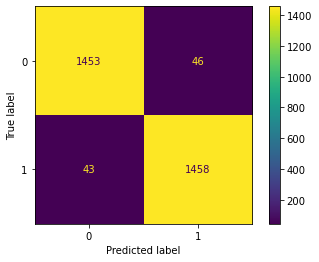

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels=np.argmax(test_y, axis=1)
cm=confusion_matrix(preds, labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [68]:
from sklearn import metrics
print('acc: ', metrics.accuracy_score(labels, preds))
print('pre: ', metrics.precision_score(labels, preds, average='macro'))
print('rcl: ', metrics.recall_score(labels, preds, average='macro'))
print('f1: ', metrics.f1_score(labels, preds, average='macro'))

acc:  0.9703333333333334
pre:  0.9703326534811794
rcl:  0.9703357890544999
f1:  0.970333250925697
